In [17]:
from torchvision import transforms
import torch
import torchvision.models as models
from PIL import Image


In [18]:
# Load the pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Modify the last fully connected layer to have 250 output features
num_features = 250
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_features)


C:\Users\yamrs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yamrs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Define the root directory where your "images" folder is located
root_directory = "dtd-r1.0.1/dtd/images"

# Create a list of all image file extensions you want to consider (e.g., '.jpg', '.png')
image_extensions = ['.jpg', '.png', '.jpeg']

In [20]:
resnet_features = []

In [21]:
import os

In [22]:
# Set the model to evaluation mode
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
from PIL import Image
for folder_name, subfolders, filenames in os.walk(root_directory):
    for filename in filenames:
        # Check if the file is an image (you can add more image file extensions as needed).
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Construct the full path to the image.
            image_path = os.path.join(folder_name, filename)

            img = Image.open(image_path)
            preprocess = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
            img = preprocess(img).unsqueeze(0)  # Add a batch dimension

            # Forward pass to extract features
            with torch.no_grad():
                features = resnet(img)

            # Assuming you have a PyTorch tensor named 'features'
            feature_list = features.tolist()
            #print(feature_list)
                
            resnet_features.append((filename, feature_list))



In [24]:
import csv
# Define the CSV file path to save the data.
csv_file_path = "resnet_features.csv"

# Save the image name and vector data to a CSV file.
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['ImageName', 'Vector'])  # Write header row

    for image_name, vector in resnet_features:
        csv_writer.writerow([image_name, ','.join(map(str, vector))])

# RUN CODE FROM HERE

In [25]:
import numpy as np
def euclidean(a, b):
    return np.linalg.norm(a - b)
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [26]:
import csv
import numpy as np

def calculate_distances(image_name1, image_name2, csv_file_path="resnet_features.csv"):
    vector1 = None
    vector2 = None
    
    # Read the CSV file to get the vectors for the given image names.
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if row[0] == image_name1:
                # Remove brackets and convert to a list of floats
                vector1 = np.array([float(val) for val in row[1][1:-1].split(',')])
            if row[0] == image_name2:
                # Remove brackets and convert to a list of floats
                vector2 = np.array([float(val) for val in row[1][1:-1].split(',')])

    if vector1 is None or vector2 is None:
        print("One or both of the images were not found in the CSV file.")
        return

    # Calculate Euclidean distance and cosine similarity between the vectors.
    euclidean_distance = euclidean(vector1, vector2)
    cosine_similarity = cosine(vector1, vector2)

    return euclidean_distance, cosine_similarity

val = calculate_distances("banded_0002.jpg", "banded_0004.jpg")

print("Euclidean Distance:", val[0])
print("Cosine Similarity:", val[1])


Euclidean Distance: 2.9390679305069103
Cosine Similarity: 0.8256638998799397


In [27]:

# Define a function to search for the most similar images.
def search(query_image_path, csv_file_path, top_k=5):
    # Open the query image using PIL.
    query_image = Image.open(query_image_path)
    query_image_array = np.array(query_image)

    img = Image.open(image_path)
    preprocess = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    img = preprocess(img).unsqueeze(0)  # Add a batch dimension

    # Forward pass to extract features
    with torch.no_grad():
        features = resnet(img)

    # Assuming you have a PyTorch tensor named 'features'
    query_vector = features.tolist()

    # Read the CSV file to get image vectors.
    image_data_list = []
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            image_name = row[0]
            vector = np.array([float(val) for val in row[1][1:-1].split(',')])
            image_data_list.append((image_name, vector))

    # Calculate cosine and Euclidean distances between the query vector and all other vectors.
    cosine_similarities = []
    euclidean_distances = []
    for image_name, vector in image_data_list:
        cosine_similarity = cosine(query_vector, vector)
        euclidean_distance = euclidean(query_vector , vector)
        cosine_similarities.append((image_name, cosine_similarity))
        euclidean_distances.append((image_name, euclidean_distance))

    # Sort the images by similarity/distance in descending order.
    top_cosine_similar_images = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)[:top_k]
    top_euclidean_similar_images = sorted(euclidean_distances, key=lambda x: x[1])[:top_k]

    return top_cosine_similar_images, top_euclidean_similar_images, query_vector



In [28]:

from PIL import Image
query_image_path = "dtd-r1.0.1/dtd/images/cobwebbed/cobwebbed_0030.jpg"

cosine_results, euclidean_results,query_vector  = search( query_image_path, 'resnet_features.csv', top_k=5)

#Print the vector of the query image, and the top-k similar images along with their similarity/distance scores.
#print("Query Image Vector:", query_vector)
print("\nTop 5 Cosine Similar Images:")
for i, (image_name, similarity) in enumerate(cosine_results, 1):
    print(f"Top {i}: {image_name} (Similarity: {similarity:})")

print("\nTop 5 Euclidean Distance Images:")
for i, (image_name, distance) in enumerate(euclidean_results, 1):
    print(f"Top {i}: {image_name} (Euclidean Distance: {distance:.4f})")





Top 5 Cosine Similar Images:
Top 1: zigzagged_0133.jpg (Similarity: [1.])
Top 2: zigzagged_0122.jpg (Similarity: [0.84398335])
Top 3: zigzagged_0125.jpg (Similarity: [0.83750578])
Top 4: zigzagged_0109.jpg (Similarity: [0.83044281])
Top 5: chequered_0150.jpg (Similarity: [0.79876411])

Top 5 Euclidean Distance Images:
Top 1: zigzagged_0133.jpg (Euclidean Distance: 0.0000)
Top 2: zigzagged_0125.jpg (Euclidean Distance: 3.7715)
Top 3: zigzagged_0122.jpg (Euclidean Distance: 3.8132)
Top 4: chequered_0150.jpg (Euclidean Distance: 4.1513)
Top 5: chequered_0114.jpg (Euclidean Distance: 4.2933)


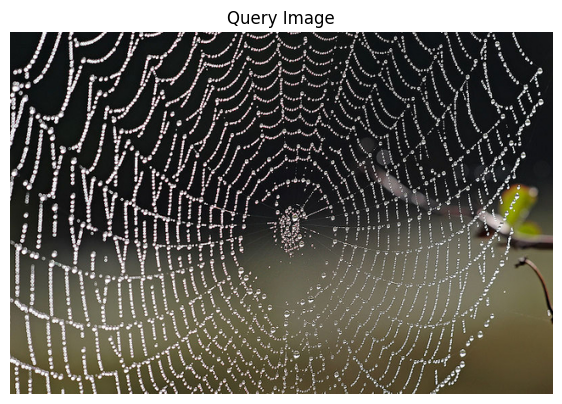

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the query image using PIL.
query_image = Image.open(query_image_path)
query_image_array = np.array(query_image)

# Visualize the query image
plt.figure(figsize=(7, 7))
plt.imshow(query_image_array)
plt.title('Query Image')
plt.axis('off')
plt.show()


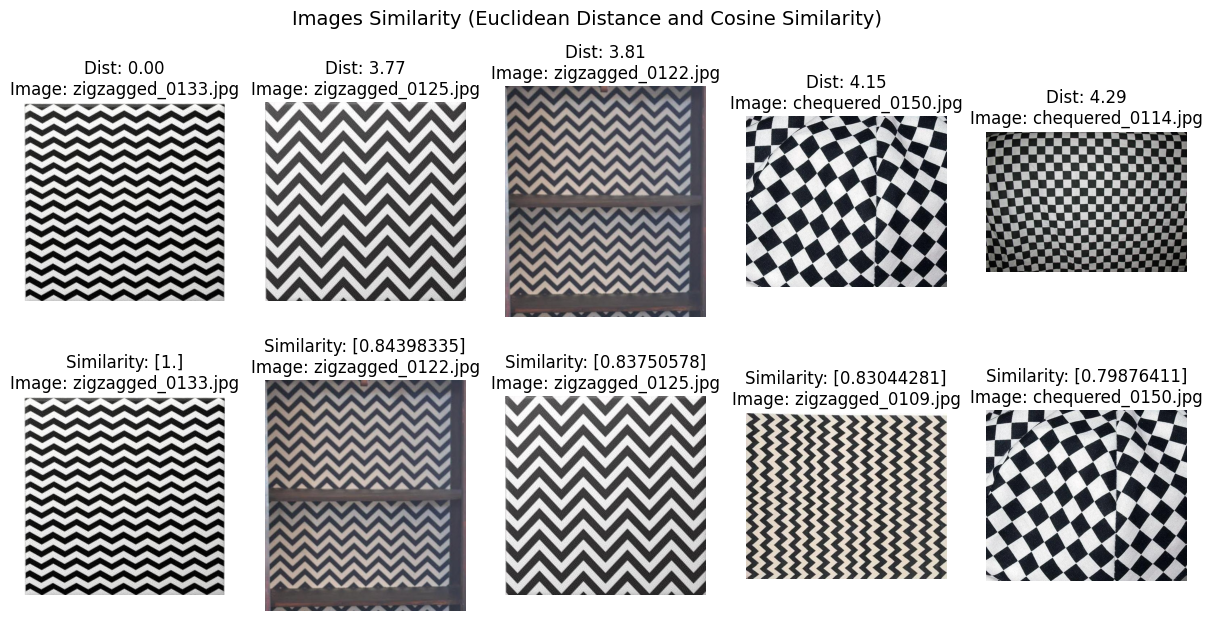

In [30]:
import re

from PIL import Image

top_k = 5

# Regular expression pattern to remove numbers, "jpg", and underscores
pattern = r'\d+|\.jpg|_'

fig, axes = plt.subplots(2, top_k, figsize=(15, 7))
fig.suptitle('Images Similarity (Euclidean Distance and Cosine Similarity)', fontsize=14)

# Plot the closest images based on Euclidean distance.
for i, (image_name, distance) in enumerate(euclidean_results[:top_k]):
    # Clean the image_name to remove numbers, "jpg," and underscores
    cleaned_file_path = re.sub(pattern, '', image_name)

    # Construct the full path to the image
    image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

    # Open and plot the image
    image = Image.open(image_path)
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Dist: {distance:.2f}\nImage: {image_name}')
    axes[0, i].axis('off')

# Plot the closest images based on Cosine similarity.
for i, (image_name, similarity) in enumerate(cosine_results[:top_k]):
    # Clean the image_name to remove numbers, "jpg," and underscores
    cleaned_file_path = re.sub(pattern, '', image_name)

    # Construct the full path to the image
    image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

    # Open and plot the image
    image = Image.open(image_path)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f'Similarity: {similarity:}\nImage: {image_name}')
    axes[1, i].axis('off')

plt.show()


In [33]:
import csv
import time
import re

import csv
import time
import re

pattern = r'\d+|\.jpg|_'

def calculate_precision_at_k(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'
    total = 0

    for result in top_k_results:
        filename, _ = result
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            print("true")
            # print(true_image)
            # print(filename)
            total += 1
            
            
        else:
            print("false")
            # print(true_image)
            # print(filename)
        
        return total
    

def calculate_precision_at_1(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'

    if top_k_results:
        filename, _ = top_k_results[0]
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            return 1.0
        else:
            return 0.0



    

def calculate_average_precision_at_k(csv_file_path, top_k):
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        total_precision_at_k = 0
        total_retrieval_time = 0
        total_precision_at_1 = 0
        total_images = 0
        top_k = 10

        for row in csv_reader:
            image_name, _ = row[0], row[1]
            cleaned_file_path = re.sub(pattern, '', image_name)
            print(image_name)
            image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
            query_image_path = image_path
            #print(query_image_path)
            start_time = time.time()
            top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
            retrieval_time = time.time() - start_time
            precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
            precision_at_1 = calculate_precision_at_1(cleaned_file_path, top_cosine_similar_images)

            total_precision_at_k += precision_at_k
            total_retrieval_time += retrieval_time
            total_precision_at_1 += precision_at_1
            total_images += 1

    average_precision_at_k = total_precision_at_k / total_images
    average_retrieval_time = total_retrieval_time / total_images
    print("total_images: ", total_images)
    print("total_precision_at_k: ", total_precision_at_k)
    print("total_retrieval_time: ",total_retrieval_time)

    return average_precision_at_k, average_retrieval_time, total_precision_at_1

csv_file_path = 'resnet_features.csv'
top_k = 10  # You can change this value as needed

average_precision_at_10, average_retrieval_time, total_precision_at_1 = calculate_average_precision_at_k(csv_file_path, top_k)

print(f'Average Precision at {top_k}: {average_precision_at_10}')
print(f'Average Retrieval Time: {average_retrieval_time} seconds')
print(f'Average Precision at 1: {total_precision_at_1}')


banded_0002.jpg
false
banded_0004.jpg
false
banded_0005.jpg
false
banded_0006.jpg
false
banded_0008.jpg
false
banded_0009.jpg
false
banded_0010.jpg
false
banded_0011.jpg
false
banded_0012.jpg
false
banded_0013.jpg
false
banded_0016.jpg
false
banded_0019.jpg
false
banded_0021.jpg
false
banded_0022.jpg
false
banded_0023.jpg
false
banded_0024.jpg
false
banded_0025.jpg
false
banded_0030.jpg
false
banded_0033.jpg
false
banded_0034.jpg
false
banded_0036.jpg
false
banded_0037.jpg
false
banded_0039.jpg
false
banded_0041.jpg
false
banded_0042.jpg
false
banded_0043.jpg
false
banded_0044.jpg
false
banded_0045.jpg
false
banded_0046.jpg
false
banded_0047.jpg
false
banded_0049.jpg
false
banded_0051.jpg
false
banded_0053.jpg
false
banded_0055.jpg
false
banded_0057.jpg
false
banded_0058.jpg
false
banded_0059.jpg
false
banded_0060.jpg
false
banded_0061.jpg
false
banded_0062.jpg
false
banded_0063.jpg
false
banded_0064.jpg
false
banded_0066.jpg
false
banded_0067.jpg
false
banded_0068.jpg
false
banded_006

In [34]:
import csv
import time
import re
import numpy as np
import matplotlib.pyplot as plt

# Define the pattern and functions for precision calculation as shown in your code

def calculate_precision_recall_curve(csv_file_path, thresholds, precisions, recalls):
    for threshold in thresholds:
        with open(csv_file_path, 'r') as csvfile:
            csv_reader = csv.reader(csvfile)
            next(csv_reader)  # Skip the header row
            total_precision_at_k = 0
            total_images = 0

            for row in csv_reader:
                image_name, _ = row[0], row[1]
                cleaned_file_path = re.sub(pattern, '', image_name)
                image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
                query_image_path = image_path
                top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
                precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
                total_precision_at_k += precision_at_k
                total_images += 1

        average_precision_at_k = total_precision_at_k / total_images
        precisions.append(average_precision_at_k)
        recalls.append(total_images)

    return precisions, recalls

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(precisions, recalls):
    plt.plot(recalls, precisions, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

# Define your CSV file path, thresholds, precisions, and recalls
csv_file_path = 'resnet_features.csv'
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define the thresholds you want to use
precisions = []
recalls = []

precisions, recalls = calculate_precision_recall_curve(csv_file_path, thresholds, precisions, recalls)
plot_precision_recall_curve(precisions, recalls)


false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
fals

KeyboardInterrupt: 